# Answers, week 06: _Student's game night_
__Sean's version__

First, our imports.

In [1]:
import numpy as np              
import scipy.stats as stats     # stats.norm.pdf() : P(x | mu, sigma) for the Gaussian
import scipy.special as special # logsumexp() is here
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

## 1. the beginner's game

We're to:

* take as input n observations x_1..x_n (positions of dropped tea bags) and a known $\sigma$.
* calculate the posterior probability $P(\mu \mid x_i..x_n, \sigma)$ for each of the 21 possible values of $\mu$ on Student's grid row, for that $\sigma$
* plot that $P(\mu \mid \cdot)$ distribution on a semilogy scale.
* and plot the pub's calculated probability distribution

In my solution, I'm going to go ahead and set up the solution to both parts of the problem, the beginner's game and the advanced game. I figured it would be easier when you're working through the pset to think in terms of the known sigma, then move on to the case of the unknown sigma and the extra marginalization you have to do, over its uncertainty. But once you understand the calculations, the solution to the beginner's game is just a matter of pulling the right row out of the posterior distribution and normalizing it.

### Set the observed data

In [2]:
# The pset suggested using the following example:
X  = np.array([11.50, -2.32, 9.18])   # n=3 observations
nX = 3

true_sigma = 60.      # Student tells us the true sigma, in the beginner's game
true_mu    = -20.     # The true mu is unknown, but for the sake of the example, I told you.
                      # The real data happened to all come out to the right of the true mu, by chance.

### some setup: Student's grid

In [13]:
# Set up the complete 20x21 dart board grid, and the mu and sigma values
# associated with each grid position.
#
# In the beginner's game, we only need one of these rows, at the true_sigma;
# get its row index.
gridrows = np.linspace( 100.0,   5.0, 20)   # rows i of the grid are sigma, std. dev.
gridcols = np.linspace(-100.,  100.0, 21)   # columns j of the grid are mu, mean (location)
nrows    = len(gridrows)
ncols    = len(gridcols)

true_row = np.where(gridrows==true_sigma)[0].item()  # numpy `where` is helpful: here, we want to get the array index of the true sigma
true_col = np.where(gridcols==true_mu)[0].item()     # but it returns an array! so convert the one element to scalar, with .item() method
true_row, true_col

(8, 8)

### Sample statistics

The pub's estimates of the odds, i.e. the posterior distribution $P(\mu | X, \sigma)$ in the beginner's game, or $P(\mu | X)$ in the advanced game, are based on the standard error of the mean, which you get from the sample mean and sample standard deviation.

A nettlesome bit here is that in classical statistics, it's easy to get confused about populations, samples, parameters, and summary statistics. The calculation for a **population standard deviation** is:

$$\sigma = \sqrt{\frac{\sum_i (x_i - \mu)^2} {N}}$$

where you assume that the population mean is the parametric $\mu$, and the observed standard deviation is the parametric $\sigma$, in the limit of an infinitely large population.

But when you only have a sample of a population you're supposed to calculate a **sample standard deviation**:

$$s = \sqrt{\frac{\sum_i (x_i - \bar{x})^2} {N-1}}$$

which is what arises as the "unbiased estimator" of $\sigma$ when we only have a sample from a larger population. The N-1 represents a "loss of one degree of freedom". My advice is to not even try to understand this, at least at this point. 

If you use the Python `statistics` module and you call `statistics.stdev()`, you get the sample standard deviation. If you use `numpy` and you call `numpy.std()`, you get the *population* standard deviation. If you pay attention to `numpy.std()`'s `ddof` argument ("delta degrees of freedom") you realize that you can pass `ddof=1` to get the sample standard deviation.

In [14]:
# Some basic statistics for the data. The pub's calculation uses these.
sample_mean  = np.mean(X)
sample_stdev = np.std(X, ddof=1)   # Setting the ddof argument (degrees of freedom) to 1
                                   # gives the 'unbiased estimator of the sample std.dev'.

### The pub's calculation of the probabilities in the beginner's game

In [15]:
def probdist_beginner(X, sigma, mu_values):
    """ 
    Given an ndarray X_1..X_n, and a known sigma;
    and a list of the mu values in each column;
    return a list of the inferred P(mu | X,sigma) for each column.
    """
    xbar = np.mean(X)
    N    = len(X)
    Pr   = [ stats.norm.pdf(x, loc=xbar, scale= sigma / np.sqrt(N)) for x in mu_values ]  # proportional to std error of the mean
    Z    = sum(Pr)                   # normalization constant
    Pr   = [ p / Z for p in Pr ]     # normalization to a discrete probability distribution
    return Pr

### Our log likelihood

Our basic currency for probability calculus is the data log likelihood,
the probability of the data if the model parameters were all known,
$\log P(X | \mu, \sigma)$.

Note that the Bayesian calculation does not work with summary statistics. It should be less confusing: there's no mean $\bar{x}$ to confuse with the parameter $\mu$, and no $s$ to confuse with the parameter $\sigma$. There's just a model, its parameters ($\mu, \sigma$), and observed data $X$.

In [16]:

def logp_X(X, mu, sigma):
    """ 
    Given: X     = a list of observed positions X_i
           mu    = specified parameter: Gaussian mean 
           sigma = specified parameter, Gaussian std.dev.

    Calculate and return log P(X | mu, sigma),
    which is \sum_i \log P(X_i | mu, sigma)
    because the samples X_i are independent.
    """
    return sum( [stats.norm.logpdf(sample, loc=mu, scale=sigma) for sample in X])


### Posterior probability calculation

Here I'm going to calculate the posterior distribution $P(\mu, \sigma \mid X)$ over the entire grid. In the beginner's game, we're told the true row $\sigma$, so after I calculate this joint, I'll pull out a conditional distribution $P(\mu \mid X, \sigma)$ from the joint.

In [17]:
# Calculate the posterior probability of each grid square.
#
# Because we specified a uniform prior, we only need to calculate the
# data likelihood at each row,col, then normalize.
#
# We do the calculation in log space because our probabilities might
# become small. Renormalizing log probabilities requires a
# "log-sum-exp" calculation, which Python provides.
#
logL = np.empty((nrows, ncols))             # rows <i = 0..nrows-1>
for row, sigma in enumerate(gridrows):      # columns <j = 0..ncols-1>
    for col, mu in enumerate(gridcols):
        logL[row,col] = logp_X(X, mu, sigma)
        
Z        = special.logsumexp(logL)        # Normalization constant, also in log space
logL     = np.subtract(logL, Z)           # Renormalization... in log space, that means subtract log Z
postprob = np.exp( logL )                 # Convert values back to probability space by exponentiating them.
                                          # Now postprob[i,j] = P(mu, sigma | X) posterior distribution.


### Marginal and conditional distributions, from the joint

Now for the beginner's game solution, I'll pull out the $P(\mu \mid X, \sigma)$. 

I could have just as easily done this as a conditional to begin with, solving only the beginner's game on a known row, rather than solving the advanced game and then extracting the beginner's game as a special case.

I also go ahead and calculate the marginal distributions $P(\mu \mid X)$ and $P(\sigma \mid X)$ here. $P(\mu \mid X)$ is what we use for the advanced game, and we'll see that we've done a discrete approximation to the **t distribution**. $P(\sigma \mid X)$ we don't use, and I still need to doublecheck to be sure, but I believe it's related to a discrete approximation to the **$\chi^2$ distribution**.

In [18]:
# Conditional distribution for mu, given true sigma
# This is the answer to the beginner's game.
#
# I could have also gotten it by only calculating (or pulling out) row logL[true_row]
# and renormalizing that.
#
mu_conddist = np.ravel(postprob[true_row])   # numpy.ravel(): flatten an n-dim array to 1D.
Z = np.sum(mu_conddist)
mu_conddist = np.divide(mu_conddist, Z)      # Marginalized distributions


# Marginal distributions:
mu_dist    = np.sum(postprob, axis=0)    # P(mu | X)    ... the answer to the advanced game.
sigma_dist = np.sum(postprob, axis=1)    # P(sigma | X) ... which we don't use, but we would if we were illustrating
                                         #                  the chi-squared distribution instead of the t distribution.

# Posterior mode over all the grid cells (our best guesses if we had to guess both)
maxpp           = postprob.max()
(maxrow,maxcol) = np.unravel_index(postprob.argmax(), postprob.shape)   # overly tricky numpy idiom. you could also find the max's with loops

# Posterior modes of marginalized mu (our best guesses if we had to guess one)
# 
mode_mu    = gridcols[ mu_dist.argmax() ]       # This is our best guess in the advanced game.
mode_col   = mu_dist.argmax()
mode_sigma = gridrows[ sigma_dist.argmax() ]

In [19]:
# Print some stuff we learned...
print ("Student's tea distribution machine shows the customers {} samples:".format(nX))
for sample in X: print("  {0:8.2f}".format(sample))
print ("")
print ("which gives a sample mean: {0:8.2f}".format(sample_mean))
print ("    and a sample std.dev.: {0:8.2f}".format(sample_stdev))
print ("")
print ("Posterior mode, overall: mu {}, sigma {}".format(gridcols[maxcol], gridrows[maxrow]))
print ("")
print ("Marginal posterior mode for mu, if sigma unknown: {}".format(mode_mu))

Student's tea distribution machine shows the customers 3 samples:
     11.50
     -2.32
      9.18

which gives a sample mean:     6.12
    and a sample std.dev.:     7.40

Posterior mode, overall: mu 10.0, sigma 10.0

Marginal posterior mode for mu, if sigma unknown: 10.0


## 1. the beginner's game

Now we're ready to start looking at plots and do our analysis, for the particular data set $X$ that we set up.

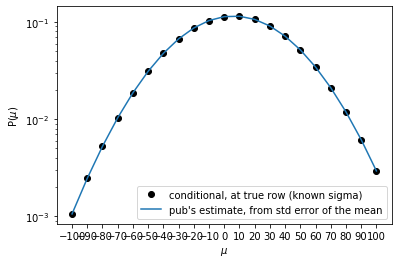

In [20]:
# For the beginner's game, we're asked to produce a plot of the posterior distribution
# P(mu | X, sigma), where we use the observed data directly; 
# and compare it to the pub's calculation, which works with summary statistics (the sample mean
# and the sample standard deviation) to calculate the standard error of the mean:
# the pub expects the true mu to be around the sample mean, with std.dev of \sigma / \sqrt(N)
#
f1, ax1 = plt.subplots()
ax1.semilogy(gridcols, mu_conddist, 'ko', label="conditional, at true row (known sigma)")

Pub   = probdist_beginner(X, true_sigma, gridcols)
ax1.semilogy(gridcols, Pub, label="pub's estimate, from std error of the mean")

ax1.xaxis.set_ticks(gridcols)
ax1.set(xlabel='$\mu$', ylabel='P($\mu$)')
ax1.legend()

### what you see there

is that the pub's estimate of the probabilities is good. If you know the true parametric $\sigma$, the standard error of the mean is a fine way of estimating the uncertain location of the parameter $\mu$, agreeing with the Bayesian calculation.

## 2. The advanced game

Now we don't know $\sigma$. Plot the entire posterior probability distribution over the 20x21 grid as a heat map:

[Text(60.51157894736846, 0.5, '$\\sigma$'), Text(0.5, 15.0, '$\\mu$')]

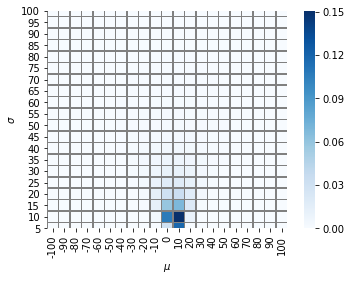

In [21]:
f2, ax2 = plt.subplots()
xlabels = [ "{0:.0f}".format(val) for val in gridcols  ]
ylabels = [ "{0:.0f}".format(val) for val in gridrows  ]
sns.heatmap(postprob, 
            cmap='Blues',
            xticklabels=xlabels, yticklabels=ylabels, 
            square=True,
            linecolor='grey', linewidth=0.5,
            ax=ax2)

ax2.set(xlabel='$\mu$', ylabel='$\sigma$')

### what you see there

In this particular data set, the three tea bags happened to accidentally fall near each other (despite the fact that the parameter $\sigma$ is $\pm 60$) and well to the right of the true $\mu$ (which is -20). The posterior probability calculation thinks there's about a 15% chance that the dart is in $\mu = 10, \sigma = 10$. But there's a haze of uncertainty -- the background color of the heatmap is actually white, so the hazy blue is real, there's a bit of probability mass everywhere. With only three observed samples, we're very unsure of where the dart is.

### the pub's calculation, and the t distribution

The pub's calculation is again based on the standard error of the mean, using the sample standard deviation. The problem is that the three samples are just accidentally piled near each other, so the sample standard deviation is small, much smaller than the actual $\sigma$. The pub is going to end up vastly overestimating its confidence in where the dart is.

Think about all the times you've seen a figure in a paper where they've plotted a mean and a standard error of the mean, as a way of showing their confidence in their estimated mean, though they only have a small number of observed samples. Think on it and despair.

We'll compare to Student's t distribution. The t distribution is for continuous $\mu$, but here we're discretized into 21 values of $\mu$, so we have to take 21 points from the t PDF and renormalize. 

There's black magic again with the "degrees of freedom" in the Student's PDF: you have to set this to $N-1$ when you have $N$ samples from an (asymptotically infinite) population.

In [22]:
def probdist_advanced(X, mu_values):
    """ 
    Given an ndarray X_1..X_n,
    and a list of the mu values in each column;
    return a list of the inferred P(mu | X) for each column.
    """
    xbar = np.mean(X)
    s    = np.std(X, ddof=1)     # note that numpy.sd() by default calculates a population std dev; to get sample std. dev., set ddof=1
    N    = len(X)
    Pr   = [ stats.norm.pdf(x, loc=xbar, scale= s / np.sqrt(N)) for x in mu_values ]  # proportional to std error of the mean
    Z    = sum(Pr)                   # normalization constant
    Pr   = [ p / Z for p in Pr ]     # normalization to a discrete probability distribution
    return Pr

def tdist_advanced(X, mu_values):
    """ 
    Given an ndarray X_1..X_n,
    and a list of the mu values in each column;
    return a list of the inferred P(mu | X) for each column,
	according to Student's t distribution with N-1 degrees of freedom.
    """
    N    = len(X)
    xbar = np.mean(X)
    s    = np.std(X, ddof=1)
    t    = [ (xbar - mu) / (s / np.sqrt(N)) for mu in mu_values ]    # t statistic, given sample mean, sample stddev, and N
    Pr   = [ stats.t.pdf(val, N-1) for val in t ]                    # N-1 = degrees of freedom
    Z    = sum(Pr)
    Pr   = [ p / Z for p in Pr ]     # normalization to a discrete probability distribution
    return Pr


### plot of the Bayesian calculation, the pub, and the t distribution

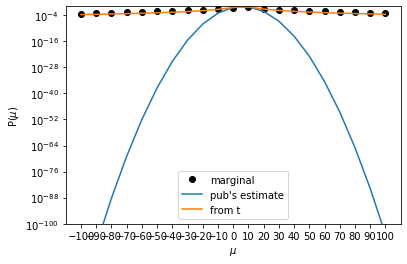

In [23]:
f3, ax3 = plt.subplots()

ax3.semilogy(gridcols, mu_dist, 'ko', label="marginal")

Pr    = probdist_advanced(X, gridcols)
ax3.semilogy(gridcols, Pr, label="pub's estimate")

Pr2   = tdist_advanced(X, gridcols)
ax3.semilogy(gridcols, Pr2, label="from t")

ax3.xaxis.set_ticks(gridcols)
ax3.set_ylim([1e-100,1.0])                     # change to [1e-5, 1.0] to zoom in on small difference between real and discretized t
ax3.set(xlabel='$\mu$', ylabel='P($\mu$)')
ax3.legend()


## Where's the advantage?

In the plot above, you can see that now the Bayesian estimate of the uncertain position of $\mu$ is vastly different from the pub's estimate. The pub is pretty sure that the dart is in a column near the average position of the tea bags, but it's been fooled by the tea bags happening to fall near each other, giving a small sample standard deviation.

**Student's t distribution** is the classical statistical distribution for the averaged sampling distribution for a sample mean $\bar{x}$, if you took lots of observed $\bar{x}$'s from a known $\mu$ but different $\sigma$'s, with all $\sigma$ being equiprobable. It does a much better job of predicting the confidence you should have in your estimate for $\mu$ when you have a small number of samples.

All the various flavors of **t-test** are based on the t distribution. One thing I wanted you to see in this exercise is that you can derive the t distribution directly as a Bayesian calculation: it's $P(\mu \mid X)$, marginalized over a uniform prior for $\sigma$. I think it's easier to remember that you're trying to quantify your uncertainty about the parameter $\mu$. You're not allowed to say that in classical statistics, so you get into contortions about "the sampling distribution of the sample mean $\bar{x}$".

To think a bit more about this as a gambling question, let's look at the estimated probabilities at the true column position of the dart, versus our best guess at it: 

In [24]:
print("At the true column of the dart, mu {}:".format(true_mu))
print("  ... the pub thinks the probability of that is {0:.3g}".format(Pr[true_col]))
print("  ... but you think the probability of that is {0:.3g}:  {1:.0g}-fold difference".format(mu_dist[true_col], 
                                                                                                mu_dist[true_col]/Pr[true_col]))
print("  ... calculating w/ t distribution gives {0:3g}".format(Pr2[true_col]))
print("")
print("At the best guess for the column of the dart, mu {}:".format(mode_mu))
print("  ... the pub thinks the probability of that is {0:.3g}".format(Pr[mode_col]))
print("  ... but you think the probability of that is {0:.3g}:  {1:.0g}-fold difference".format(mu_dist[mode_col], 
                                                                                                mu_dist[mode_col]/Pr[mode_col]))
print("  ... calculating w/ t distribution gives {0:3g}".format(Pr2[mode_col]))

At the true column of the dart, mu -20.0:
  ... the pub thinks the probability of that is 7.48e-09
  ... but you think the probability of that is 0.0273:  4e+06-fold difference
  ... calculating w/ t distribution gives 0.0104376

At the best guess for the column of the dart, mu 10.0:
  ... the pub thinks the probability of that is 0.645
  ... but you think the probability of that is 0.427:  0.7-fold difference
  ... calculating w/ t distribution gives 0.543138


We're getting minor differences between the t distribution and your Bayesian estimate because of discretization effects and edge effects. If we took a finer and finer grid, and extended it to a wider and wider range of $\sigma$ and $\mu$, we should see the Bayesian calculation converge closely to the t distribution. We did the 21x20 discretization to make the calculations fast and easy (easier, anyway), enough for you to see the gist of the issue.

There's no benefit in placing any bets at the best guess; the pub actually thinks it's more likely than you do (0.645 versus 0.427), so the pub is going to offer disfavorable odds there. You would want to bet *against* the best guess, because the pub is overestimating its confidence.

Where you can make money is by placing bets on other columns. For example, the pub might overconfidently offer you million to one odds on -20 -- probably playing it up with great publicity, MILLION TO ONE ODDS! -- and still think that it was taking a rake (the house always makes its expected winnings at least slightly positive, based on its estimate of the odds). It thinks the probability there is 7.48e-9 (about one in a hundred million). But you know the probability is actually about 3% there (0.0273). So if you place a $1 bet on -20 at million to one odds, you stand a 3% chance of winning a million dollars, which isn't too shabby.

So one good strategy is, when you see a small number of tea bags land close to each other, your best bet is to put your bets on every column *except* the mean.

Eking out an advantage in mis-estimated tail probabilities has a glorious history. In options pricing in mathematical finance, the Black-Scholes equation conceals an implicit assumption of Gaussian-distributed volatility, when true volatility is more long-tailed. I once met a Bayesian statistician who modeled options prices more realistically and proved that he had net positive expectation if he played the options markets: in theory, he could make any amount of money he wanted. The catch is demonstrated by the 3% in the example above. First you're going to wait for an unlikely occurrence (the tea bags fall close to each other) and then you're going to place your dollar bet on an unlikely fluctuation (the observed mean came out far from the true mean), because you know that when this happens, the pub has mis-estimated its risk in the tails. Even then, 97% of the time you're going to lose your dollar -- and you're also going to lose when the tea bags fall close to each other for good reason because they're near the true mean, because of a low true sigma. Because you're making your money on unlikely outcomes, you have to have enough of a stake to play the game a very large number of times so these unlikely fluctuations have a chance of appearing, so you can collect one or more wins. In Student's game, if you only had five dollars to bet, you're likely to lose it all. My Bayesian friend told me he put up 100K to try his strategy in the options markets; it wasn't enough, and he lost it all. But if you were a hedge fund with a huge stake... hrmmm, I wonder why finance firms are snapping up quants?
